In [1]:
import torch
from dlc_practical_prologue import generate_pair_sets
import torch.nn as nn
from utils import *
from utils_pipeline2 import *
import time
import models
import torch.nn.functional as F

## 1. Generate raw data, process it

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)

We normalized the data so it has mean 0 and std 1.

In [4]:
train_input = normalize_data(train_input)
test_input = normalize_data(test_input)

## 2. Creating & Training models

In [5]:
BATCH_SIZE = 64
architecture = models.SiameseNetwork
optimizer_params = {'lr': 0.05, 'momentum':0.9, 'weight_decay': 0., 'gamma': 0.97}
nb_epochs = 50

First we try to train the model without the auxiliary loss (aux_loss_alpha=0.)

In [6]:
model = architecture(nb_conv=2, final_bias=True).to(device=device)
train_accuracies, train_digit_accuracies, train_losses, \
test_accuracies, test_digit_accuracies, test_losses = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux_loss_alpha=0.)

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     125s    0.3719         99.5000        13.9000             10.2033        78.4000        15.1500             


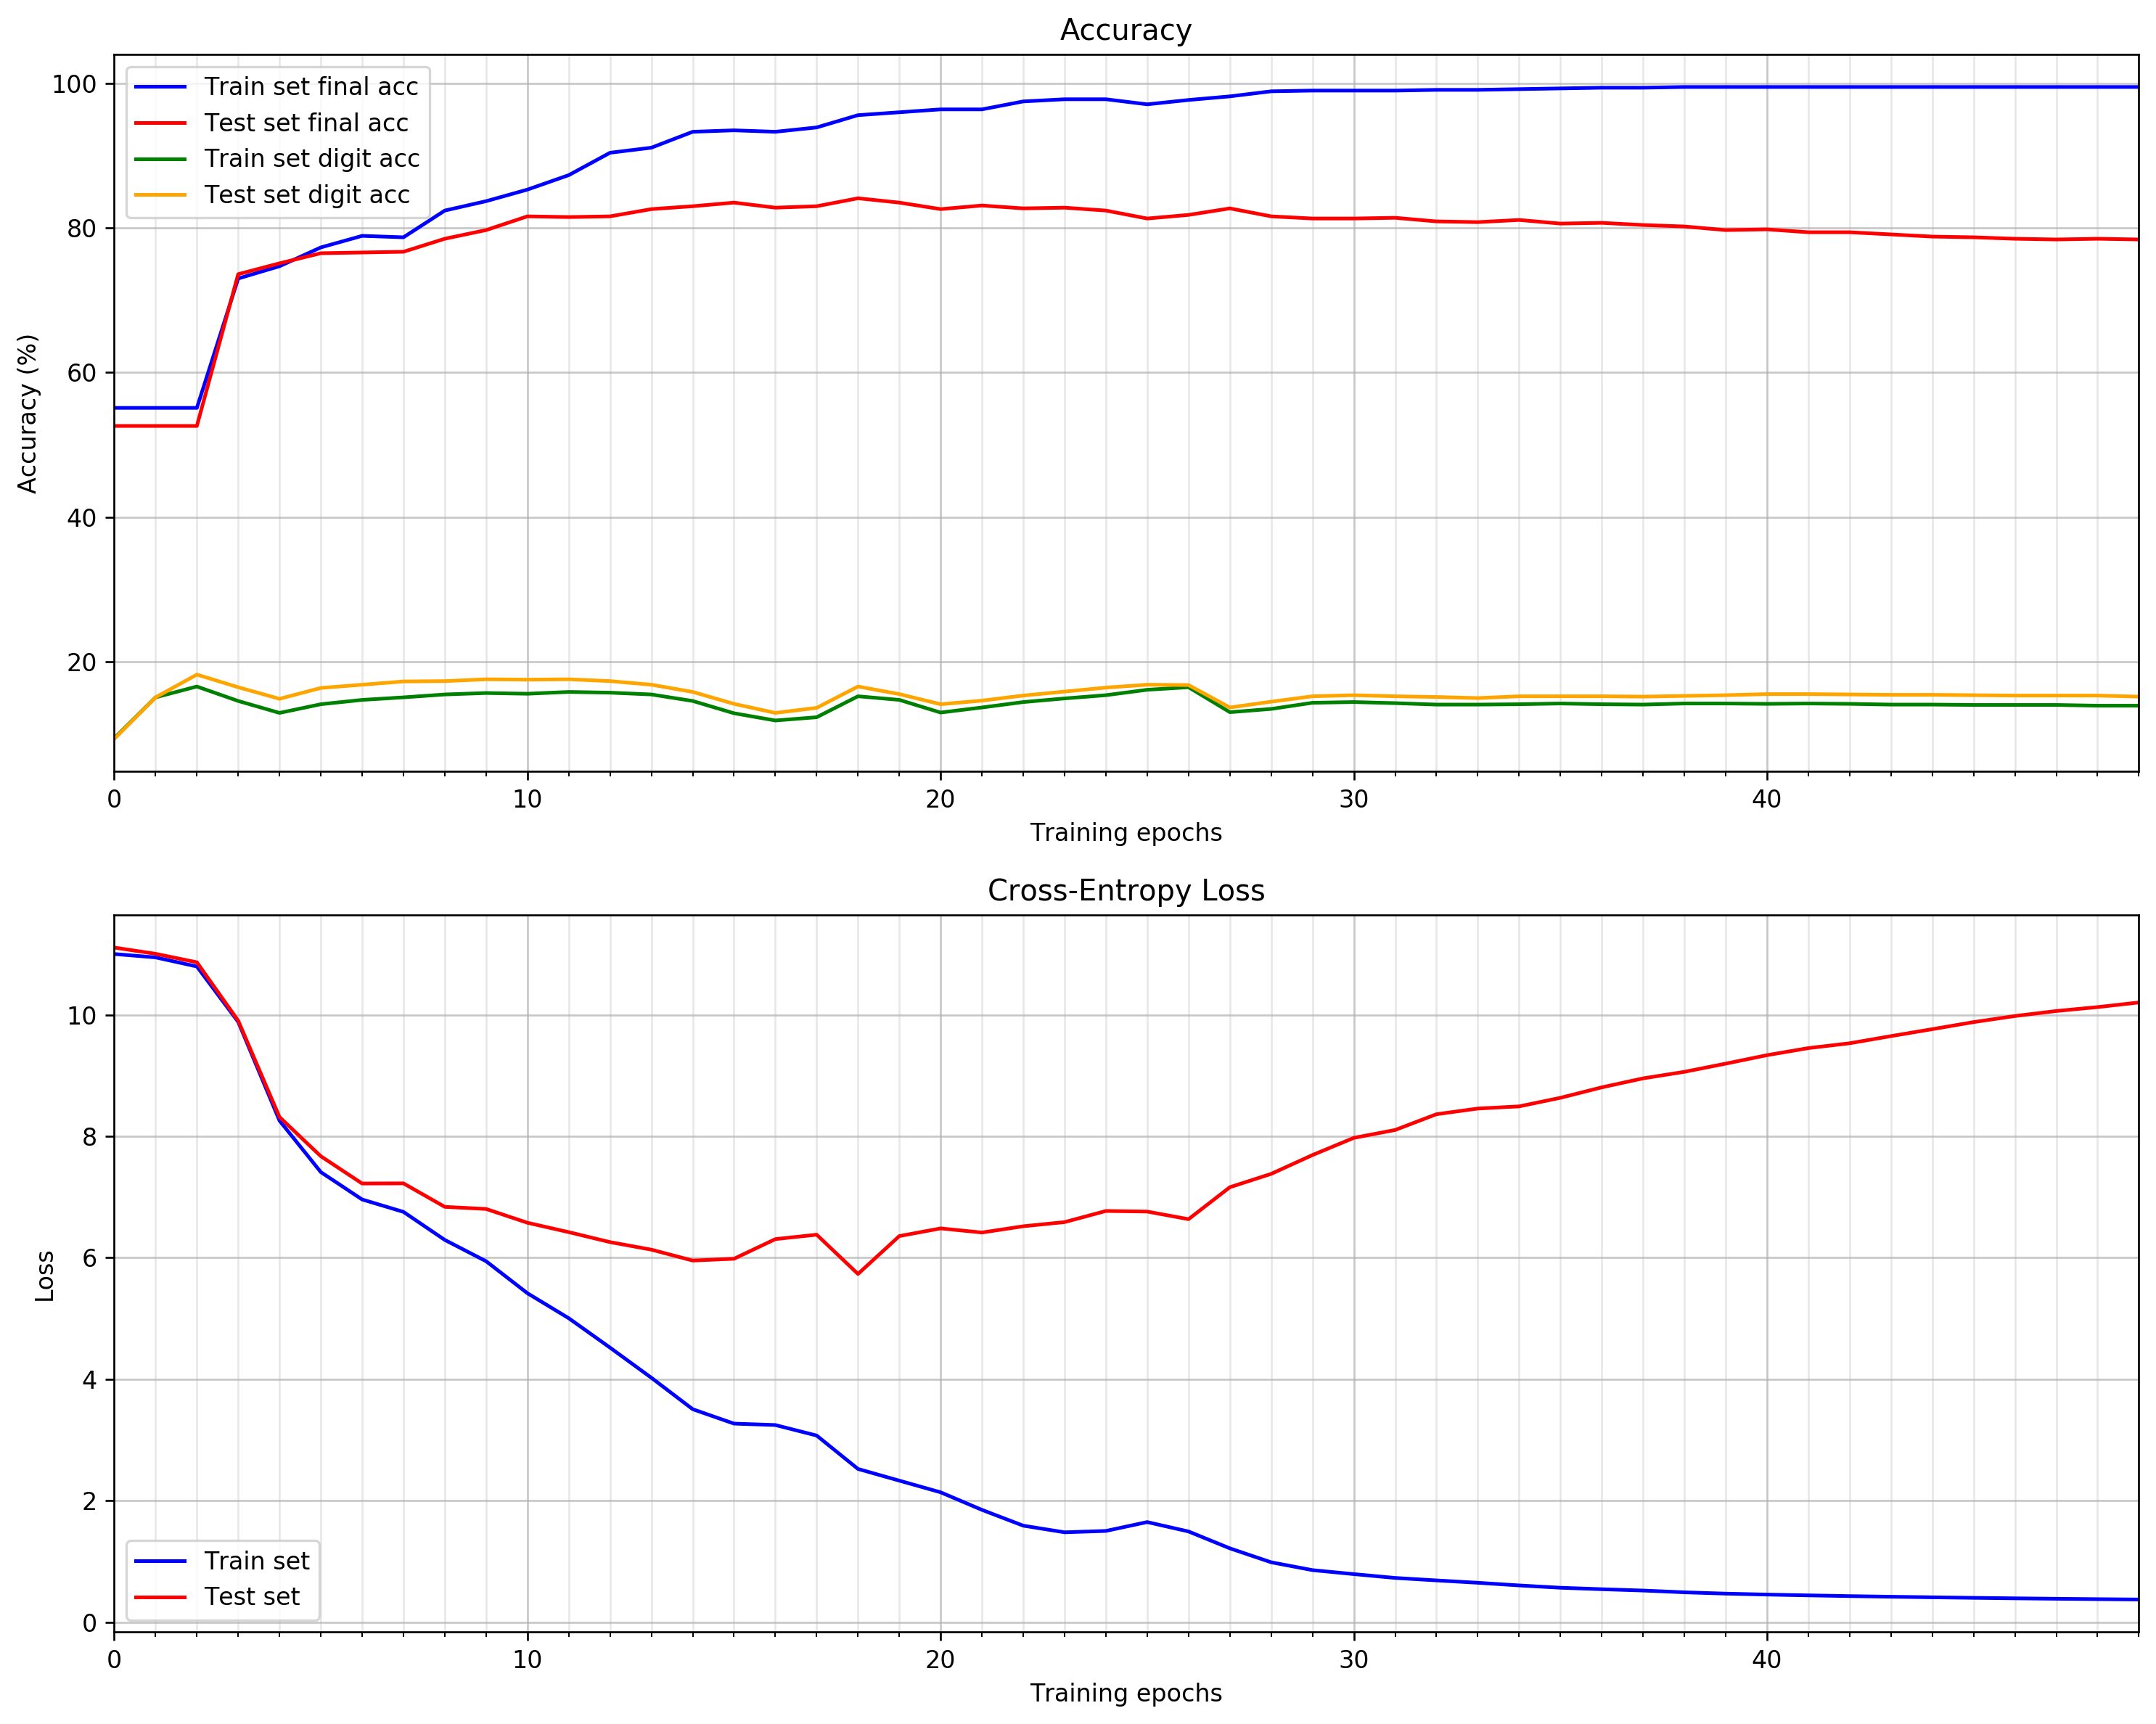

In [7]:
plot_acc_loss_aux(train_accuracies, train_digit_accuracies, train_losses, test_accuracies, test_digit_accuracies, test_losses)

We can see on the plots that the model converges quite quickly, but the final accuracy is only "decent" (78.4%) with baseline siamese network.

## 3. Finding a good auxiliary factor

We check which auxiliary loss factor is the best. We do that with a 5-fold cross-validation or each auxiliary loss tested (to reduce variance), so the next cell takes a long time to run even with a decent GPU.

In [8]:
# Too high auxiliary loss causes the training to sometimes fail to converge so we use max 0.4
aux_loss_alphas = [0.0, 0.1, 0.2, 0.3, 0.35, 0.4]
K = 5

best_aux_alpha, best_accuracy = cross_validation(architecture, K, train_input, train_target, train_classes,
                                                 device, BATCH_SIZE, nb_epochs, aux_loss_alphas, optimizer_params)

Aux loss alpha = 0.0 => Mean accuracy = 79.0
Aux loss alpha = 0.1 => Mean accuracy = 90.7
Aux loss alpha = 0.2 => Mean accuracy = 92.9
Aux loss alpha = 0.3 => Mean accuracy = 91.6
Aux loss alpha = 0.35 => Mean accuracy = 94.1
Aux loss alpha = 0.4 => Mean accuracy = 95.1


We hardcode the alpha value so that the previous cell is optional to run.

In [9]:
aux_loss_alpha = 0.4

## 4. Testing different learning schemes

### 4.1 Train digit prediction only, then comparison only

In [10]:
nb_epochs = 25
model = architecture(nb_conv=2, final_bias=True).to(device=device)
model.digit_comp_req_grad(False)  # We freeze the learning of the final linear layer for the first 25 epochs
_, _, _, _, _, _ = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux_loss_alpha=aux_loss_alpha)
model.digit_comp_req_grad(True)  # We unfreeze the learning of the final linear layer
model.digit_pred_req_grad(False)  # We freeze the learning of the digit predictor
_, _, _, _, _, _ = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux_loss_alpha=aux_loss_alpha)

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[25/25]     61s     12.1036        36.6000        100.0000            18.0782        38.0000        91.6000             
Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[25/25]     54s     2.7342         99.3000        100.0000            10.0370        94.5000        91.6000             


As we can see the digit predictor accuracy is quite good (\~92%) and the final test accuracy is already a lot better (94.5%)

### 4.2 Train digit prediction only, then everything

In [17]:
nb_epochs = 25
model = architecture(nb_conv=2, final_bias=True).to(device=device)
model.digit_comp_req_grad(False)  # We freeze the learning of the final linear layer for the first 25 epochs
_, _, _, _, _, _ = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux_loss_alpha=aux_loss_alpha)
model.digit_comp_req_grad(True)  # We unfreeze the learning of the final linear layer for the last 25 epochs
_, _, _, _, _, _ = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux_loss_alpha=aux_loss_alpha)

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[25/25]     155s    11.6600        46.5000        100.0000            15.9976        46.5000        93.3000             
Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[25/25]     160s    2.5756         99.3000        100.0000            9.2390         94.8000        92.3000             


The first learning reached a quite good test digit accuracy as before, and the final accuracy is already much better (94.8%), but sometimes the training simply fails and does not converge.

### 4.3 Train everything since the beginning

In [18]:
nb_epochs = 50
# We train everything for 50 epochs
model = architecture(nb_conv=2, final_bias=True).to(device=device)
_, _, _, _, _, _ = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux_loss_alpha=aux_loss_alpha)

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     292s    2.1461         100.0000       100.0000            8.4455         95.6000        93.1500             


Finally we try to just train everything together since the begenning, like what we did in section 2 (but with an auxiliary loss this time). Now the test accuracy is even better (95.6%) and it does not seem to ever fail training with our hyperparameters. From now on we'll only use this scheme.

## 5. Trying different depths

### 2 convolutionnal layers

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     121s    2.3243         99.6000        99.8500             9.2690         94.9000        92.4000             


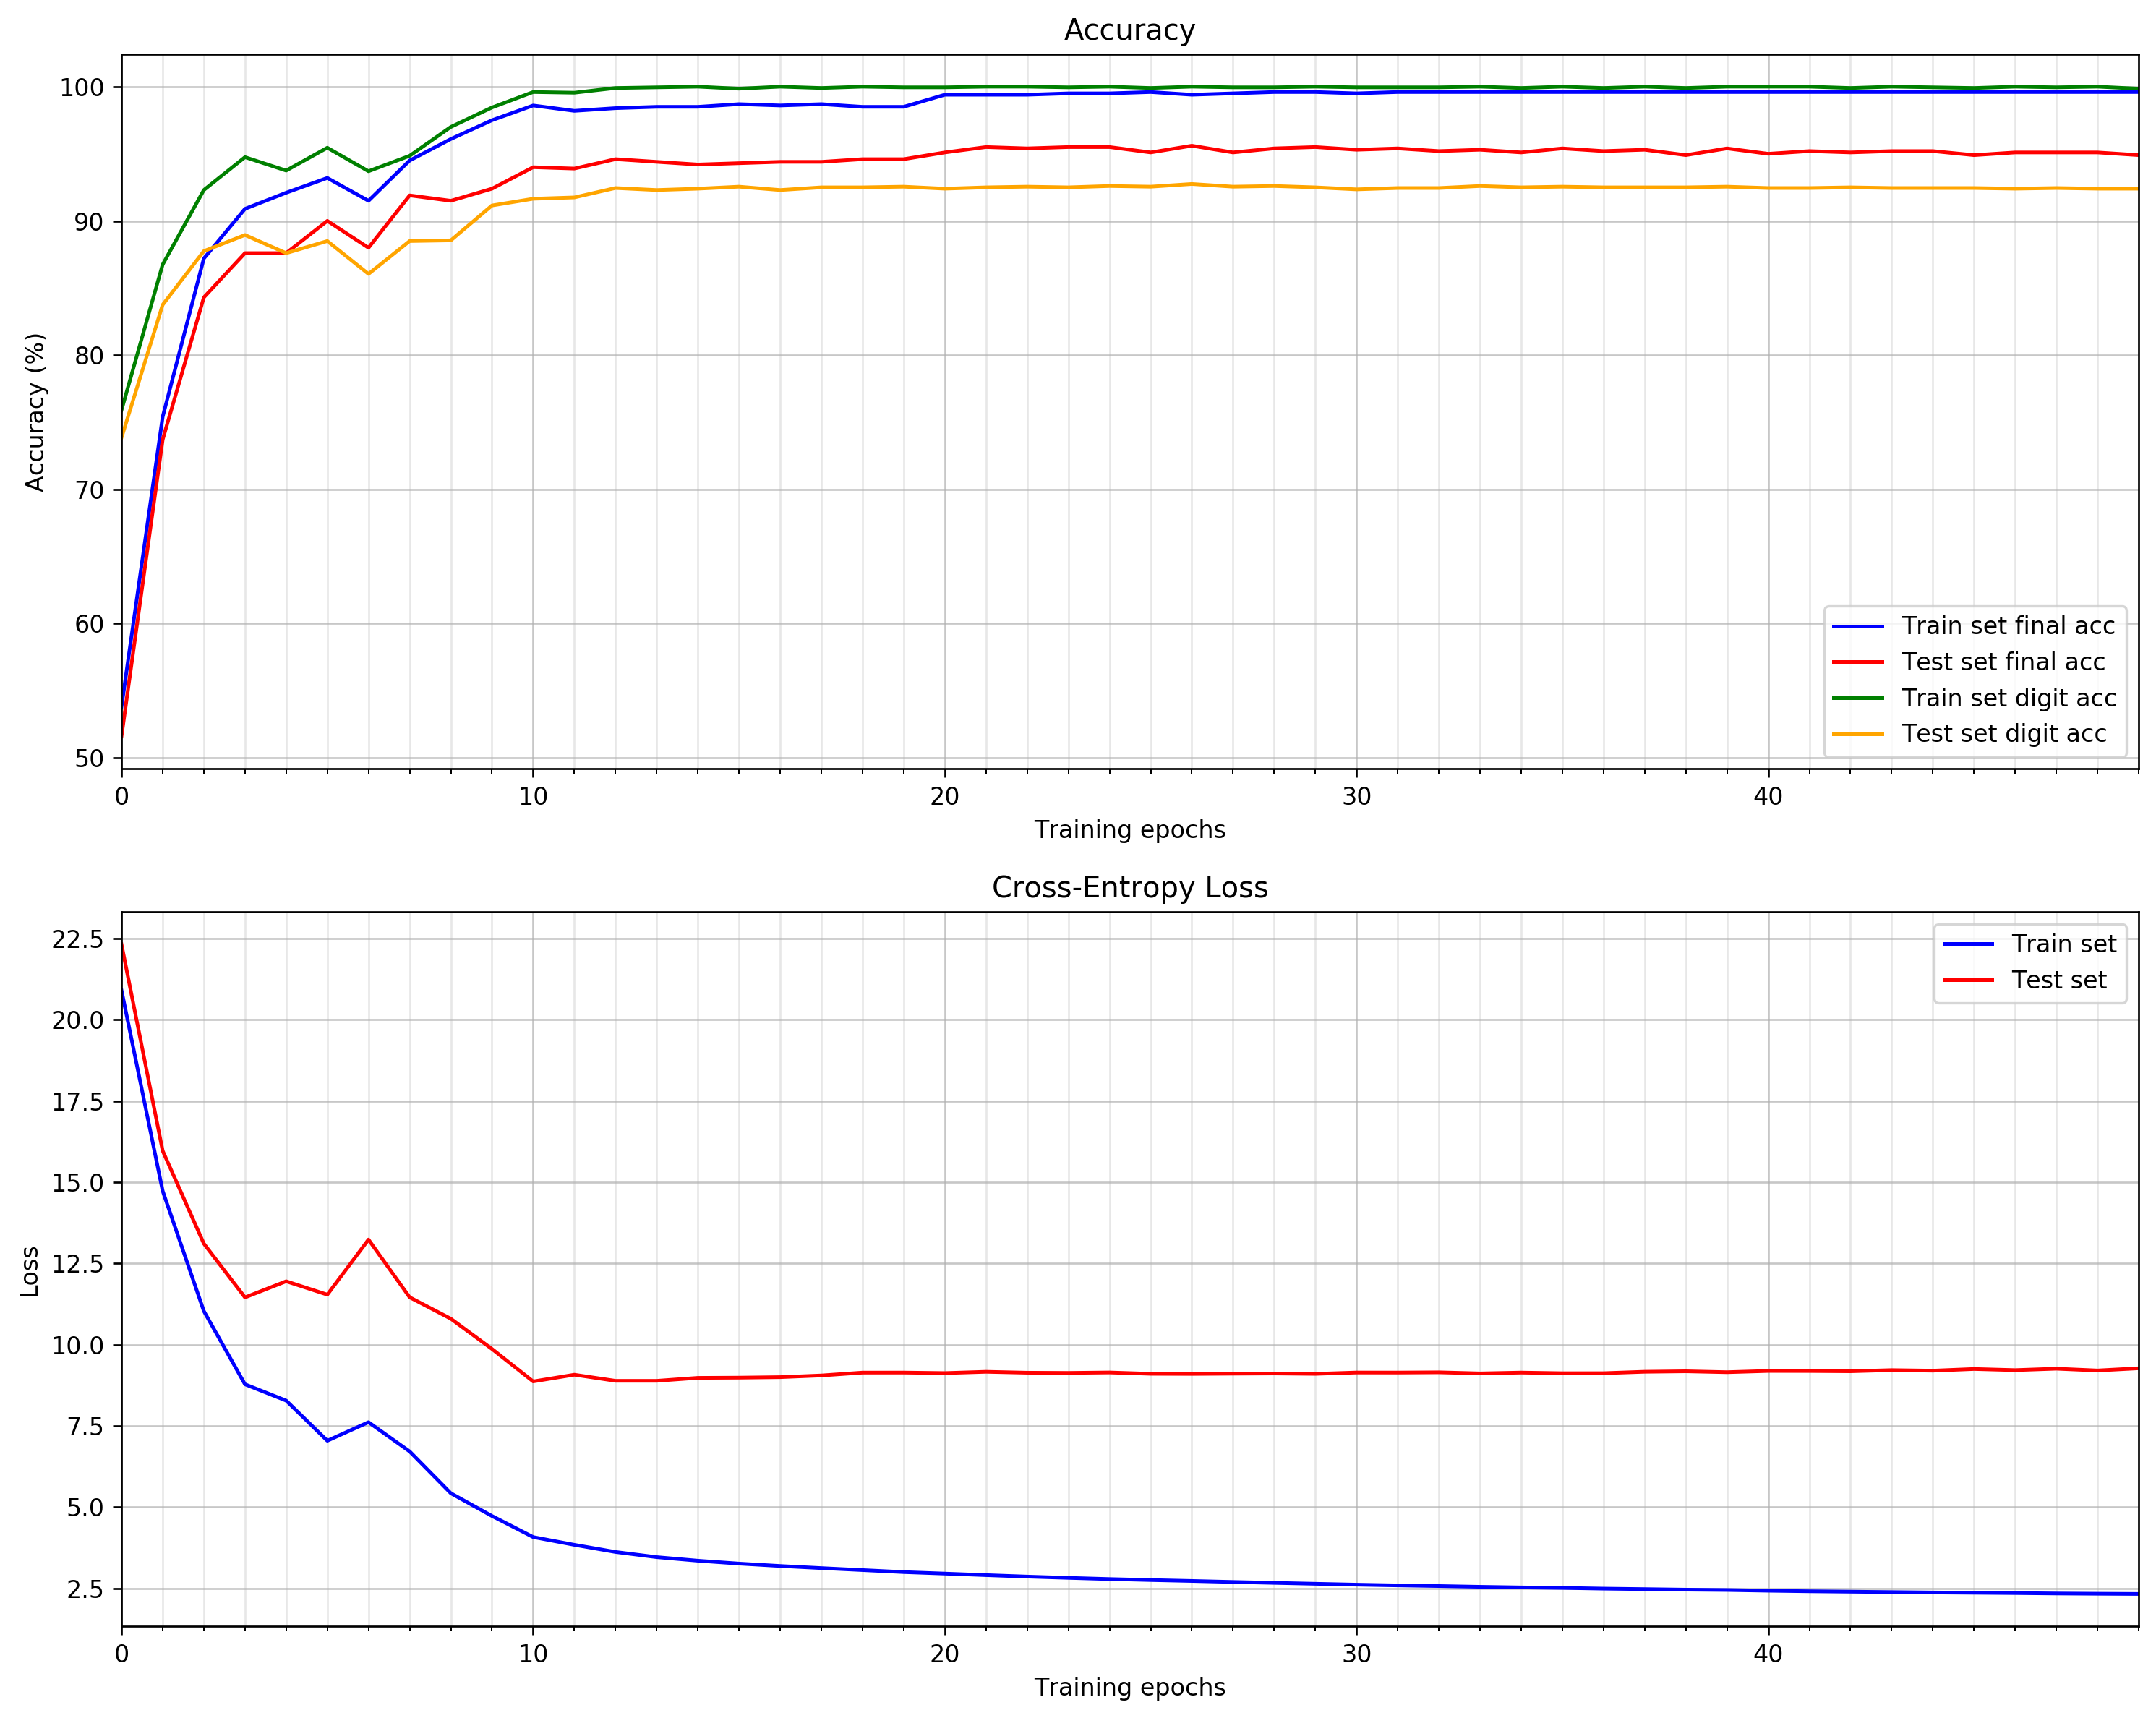

In [13]:
nb_epochs = 50
nb_conv = 2
# We train everything for 50 epochs
model = architecture(nb_conv=nb_conv, final_bias=True).to(device=device)
train_accuracies, train_digit_accuracies, train_losses, \
test_accuracies, test_digit_accuracies, test_losses = train_model(model, train_input, train_target, train_classes,
                                                       test_input, test_target, test_classes, 
                                                       nb_epochs, BATCH_SIZE, optimizer_params,
                                                       logging=True, aux_loss_alpha=aux_loss_alpha)
plot_acc_loss_aux(train_accuracies, train_digit_accuracies, train_losses, test_accuracies, test_digit_accuracies, test_losses)

### 3 convolutionnal layers

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     132s    2.3462         99.5000        99.9000             8.7878         95.6000        93.7000             


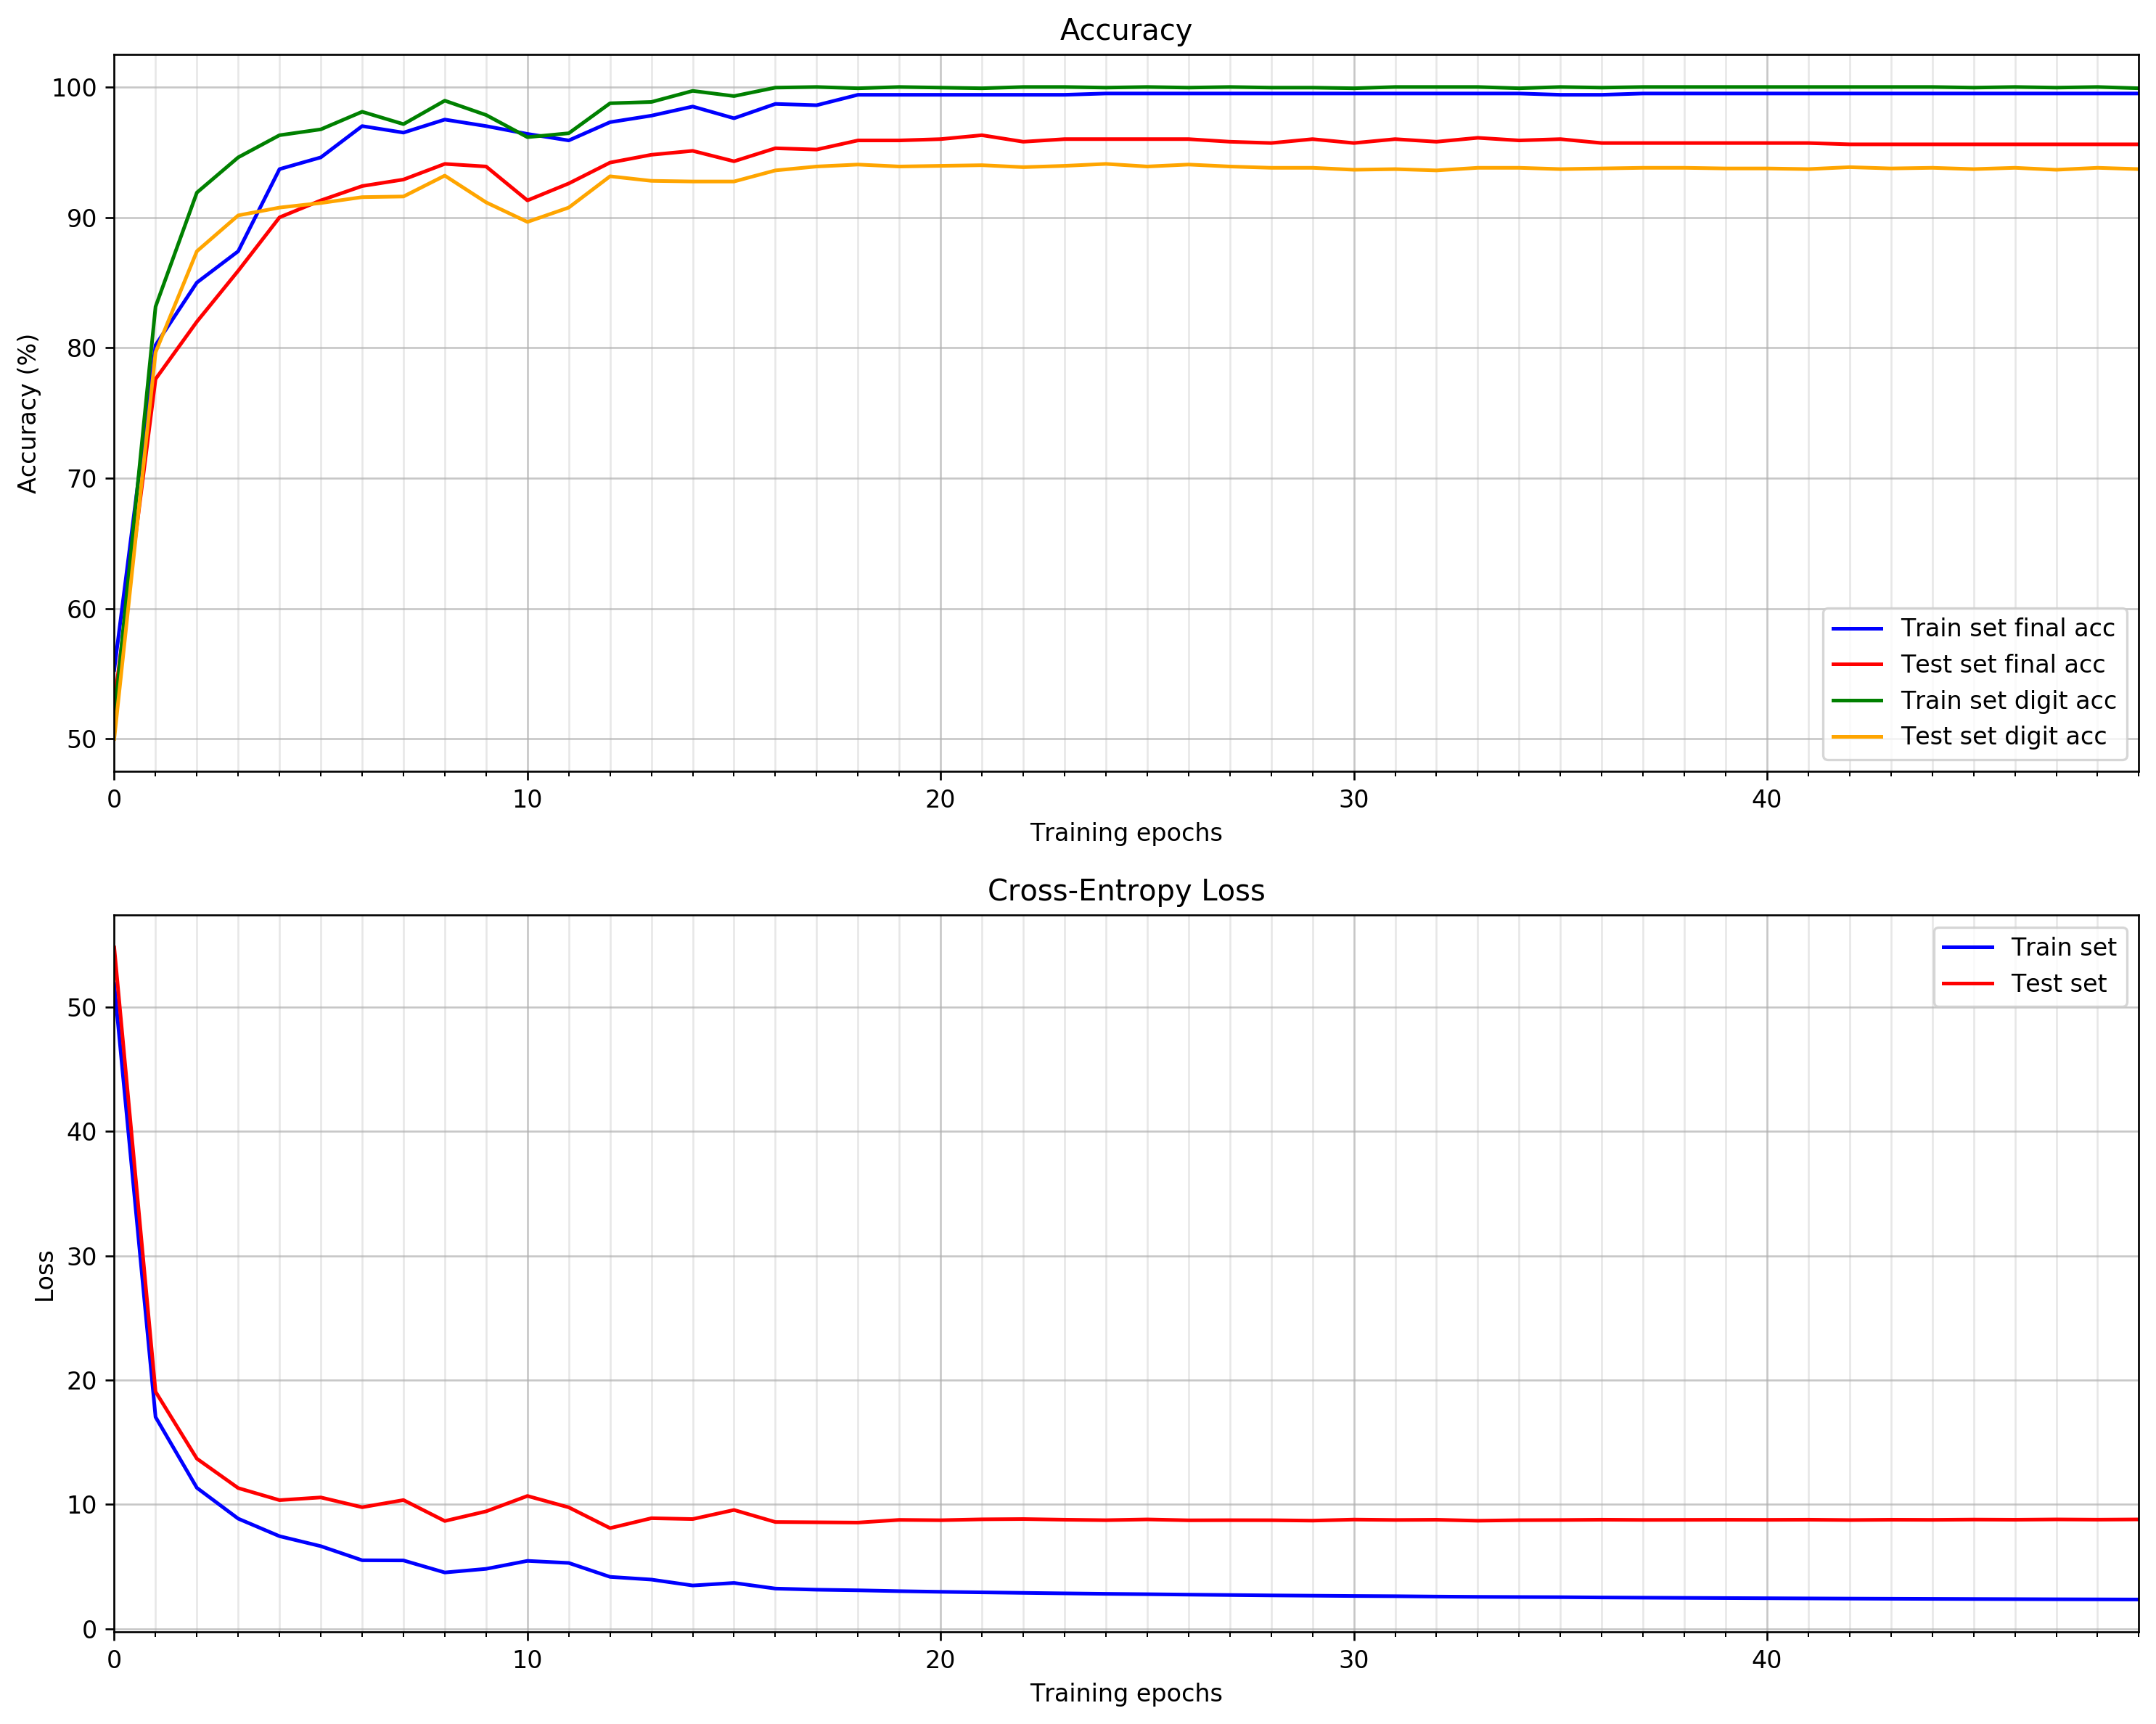

In [14]:
nb_epochs = 50
nb_conv = 3
# We train everything for 50 epochs
model = architecture(nb_conv=nb_conv, final_bias=True).to(device=device)
train_accuracies, train_digit_accuracies, train_losses, \
test_accuracies, test_digit_accuracies, test_losses = train_model(model, train_input, train_target, train_classes,
                                                       test_input, test_target, test_classes, 
                                                       nb_epochs, BATCH_SIZE, optimizer_params,
                                                       logging=True, aux_loss_alpha=aux_loss_alpha)
plot_acc_loss_aux(train_accuracies, train_digit_accuracies, train_losses, test_accuracies, test_digit_accuracies, test_losses)

### 4 convolutionnal layers

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     148s    2.3970         99.5000        99.9500             9.5050         95.8000        93.3500             


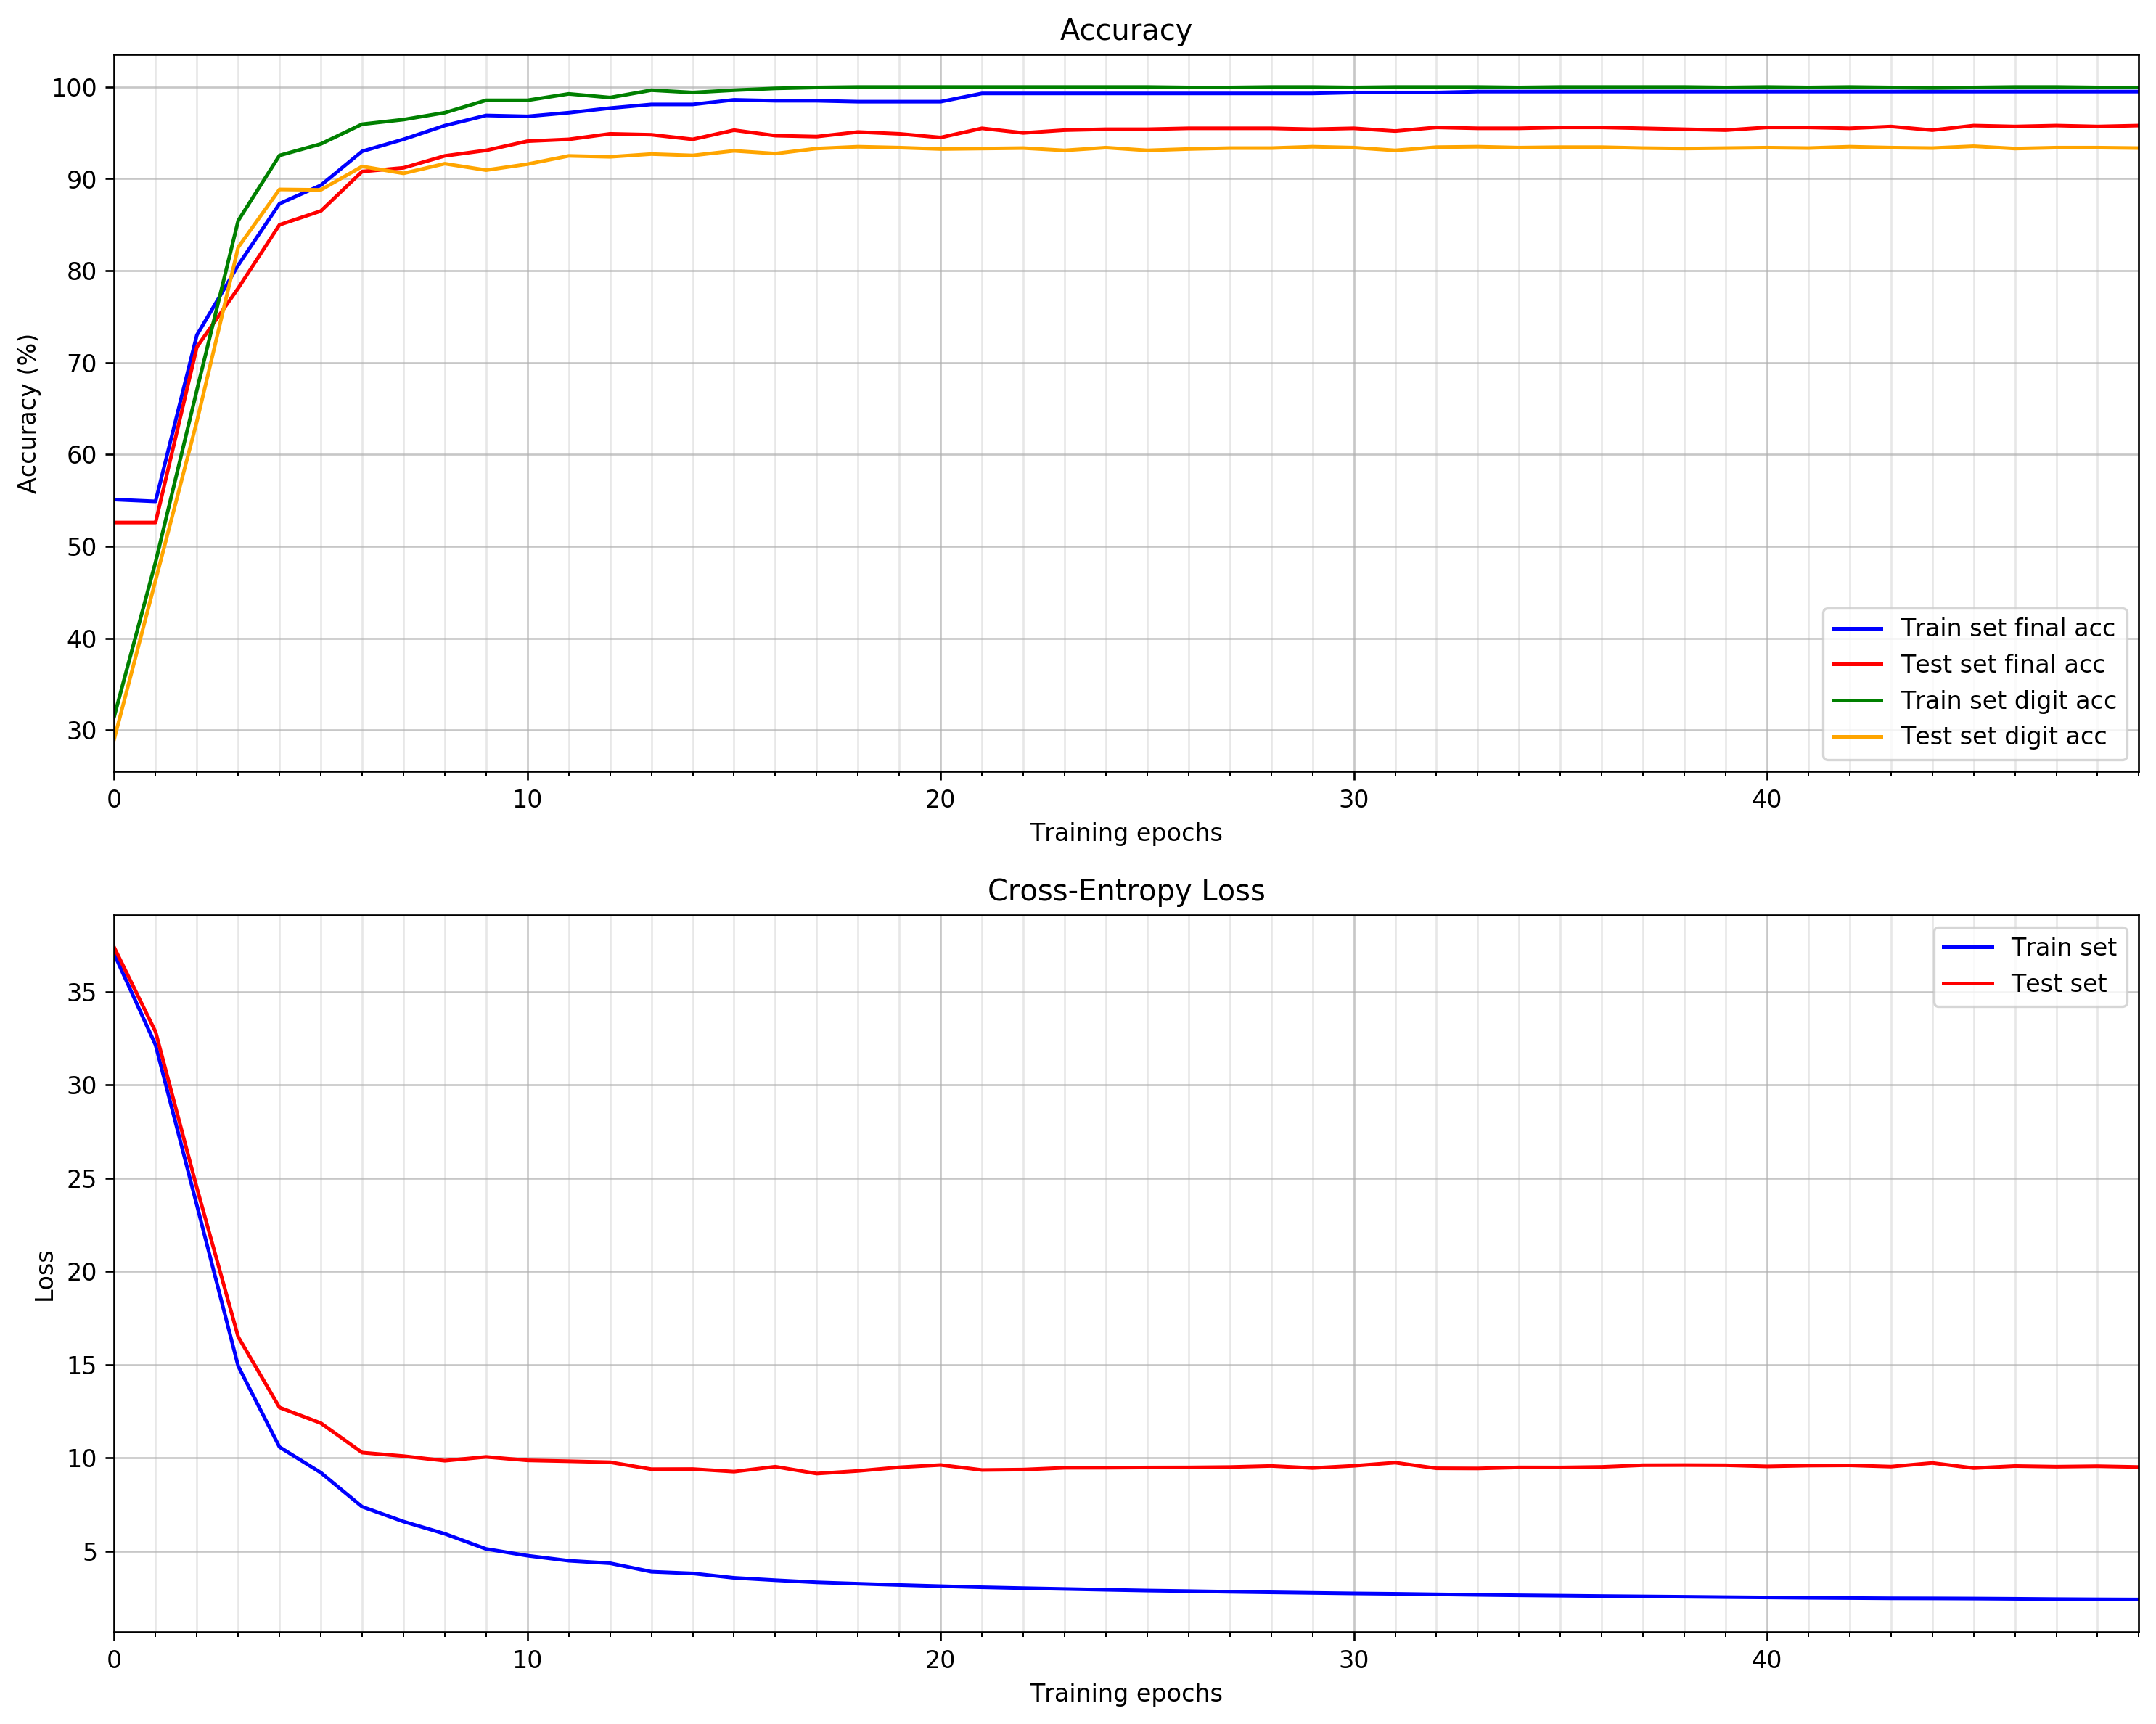

In [15]:
nb_epochs = 50
nb_conv = 4
# We train everything for 50 epochs
model = architecture(nb_conv=nb_conv, final_bias=True).to(device=device)
train_accuracies, train_digit_accuracies, train_losses, \
test_accuracies, test_digit_accuracies, test_losses = train_model(model, train_input, train_target, train_classes,
                                                       test_input, test_target, test_classes, 
                                                       nb_epochs, BATCH_SIZE, optimizer_params,
                                                       logging=True, aux_loss_alpha=aux_loss_alpha)
plot_acc_loss_aux(train_accuracies, train_digit_accuracies, train_losses, test_accuracies, test_digit_accuracies, test_losses)

The architecture with 4 convolutional layers seems to have the highest final test accuracy, but it sometimes fails while learning (accuracy is stuck at ~50%).
Also, we can see from the plots that the model with 2 convolutional layers needs less epochs to converge, but it still has a lower accuracy.
Therefore as our final model we'll use the one with 3 conv layers. We could also have adapted the optimizer parameters so that the architecture with 4 conv layers nevers fails training, but the accuracy was quite similar.

## 6. Testing model

In order to test the model we will generate new data (training and test set), retrain the model on the new data en evaluate it on the new test set. We will do this process more than 10 times and estimates the mean accuracy as well as its standard deviation.

In [16]:
optimizer_params = {'lr': 0.05, 'momentum':0.9, 'weight_decay': 0., 'gamma': 0.98}
nb_epochs = 100  # We use a bit higher gamma and more epochs
nb_conv = 3
nb_rounds = 25  # We use 25 reruns because of the high variance, reduce it to make the cell faster
accuracies = evaluate_model(architecture, nb_conv, aux_loss_alpha, nb_rounds, nn.CrossEntropyLoss(),
                            nb_epochs, BATCH_SIZE, optimizer_params, device)
print("The mean accuracy is: {a:0.2f}".format(a = accuracies.mean()))
print("The accuracy standard deviation is: {s:0.4f}".format(s = accuracies.std()))

Round       Test accuracy       Test loss      
[1/25]      95.6000             9.0848         
[2/25]      95.4000             8.2081         
[3/25]      95.3000             8.3390         
[4/25]      96.9000             7.8896         
[5/25]      95.8000             8.5537         
[6/25]      97.5000             6.4441         
[7/25]      95.6000             7.2685         
[8/25]      95.2000             10.2418        
[9/25]      94.7000             10.0342        
[10/25]     95.6000             8.4320         
[11/25]     96.1000             6.5078         
[12/25]     95.4000             8.6114         
[13/25]     95.1000             8.0630         
[14/25]     94.4000             7.6753         
[15/25]     95.4000             8.5327         
[16/25]     96.4000             8.2014         
[17/25]     95.4000             8.5599         
[18/25]     93.1000             7.9425         
[19/25]     95.6000             7.3782         
[20/25]     96.1000             7.5278  